In [67]:
import numpy as np
import pandas as pd
import itertools as it
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from scipy import linalg
from sklearn.mixture import GaussianMixture

from sklearn.cluster import AgglomerativeClustering

# Librerias para el funcionamiento del algoritmo DBSCAN
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

import scipy.cluster.hierarchy as sch

#Importamos métricas de evaluación extrínsica que se usarán para la evalución de los distintos algoritmos
from sklearn.metrics import calinski_harabasz_score, silhouette_score

In [68]:
file_url = "https://raw.githubusercontent.com/jignacioh/ActividadAprendizaNoSupervisado/master/telefonos_clasificacion/train.csv"


data = pd.read_csv(file_url) 
Dy=data['price_range'].to_numpy()
Dx=data[['ram','battery_power']].to_numpy()

column_names = ["calinski_harabasz", "silhouette_score"]
df = pd.DataFrame(columns = column_names)


### Kmeans

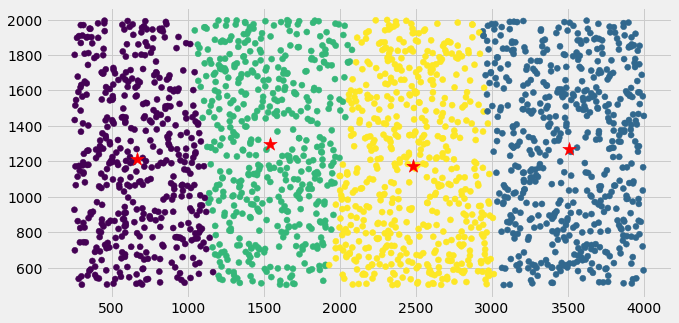

In [53]:

# Se inicializa KMeans con el número de clústeres a buscar
modelo = KMeans(n_clusters=4)
# Se aprende el 
modelo = modelo.fit(Dx)
# Predicting the clusters
Dy_kmeans = modelo.predict(Dx)
# Obtener los centros de los clústeres
cDx_sk = modelo.cluster_centers_

# Ver asignaciones finales
fig, ax = plt.subplots(figsize=(10,5))
ax.scatter(Dx[:,0],Dx[:,1], c=Dy_kmeans)
ax.scatter(cDx_sk[:,0],cDx_sk[:,1], marker='*', s=200, c='r')


In [54]:
df.loc['kmeans'] = [calinski_harabasz_score(Dx, Dyp_sk),silhouette_score(Dx,Dyp_sk) ]
df

,calinski_harabasz,silhouette_score
kmeans,2791.029018,0.35371


### Aglomerativo

Text(0, 0.5, 'Distancia euclideana')

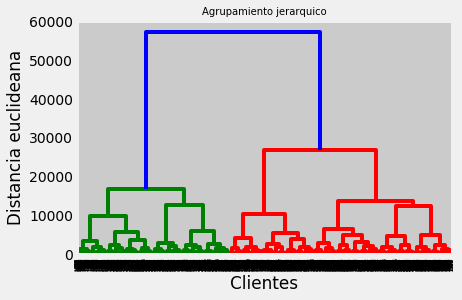

In [55]:
#Realizamos la gráfica a través del método de scipy llamado dendrograme. Como parametros le pasamos 
dendrogram = sch.dendrogram(sch.linkage(Dx, method = 'ward'))
plt.title('Agrupamiento jerarquico', fontsize = 10)

In [56]:
hc = AgglomerativeClustering(n_clusters = 4, affinity = 'euclidean', linkage = 'ward')
Dy_aglomerativo = hc.fit_predict(Dx)

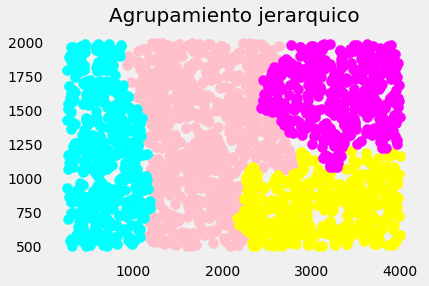

In [59]:
plt.scatter(Dx[Dy_aglomerativo == 0, 0], Dx[Dy_aglomerativo == 0, 1], s = 100, c = 'pink')
plt.scatter(Dx[Dy_aglomerativo == 1, 0], Dx[Dy_aglomerativo == 1, 1], s = 100, c = 'yellow')
plt.scatter(Dx[Dy_aglomerativo == 2, 0], Dx[Dy_aglomerativo == 2, 1], s = 100, c = 'cyan')
plt.scatter(Dx[Dy_aglomerativo == 3, 0], Dx[Dy_aglomerativo == 3, 1], s = 100, c = 'magenta')

plt.style.use('fivethirtyeight')
plt.title('Agrupamiento jerarquico', fontsize = 20)
plt.grid()
plt.show()

In [40]:
df.loc['algomerativo'] = [calinski_harabasz_score(Dx, Dy_aglomerativo),silhouette_score(Dx,Dy_aglomerativo) ]
df

,calinski_harabasz,silhouette_score
kmeans,2791.029018,0.353710
algomerativo,2369.833466,0.335606


## AGRUPAMIENTO ESPECTRAL

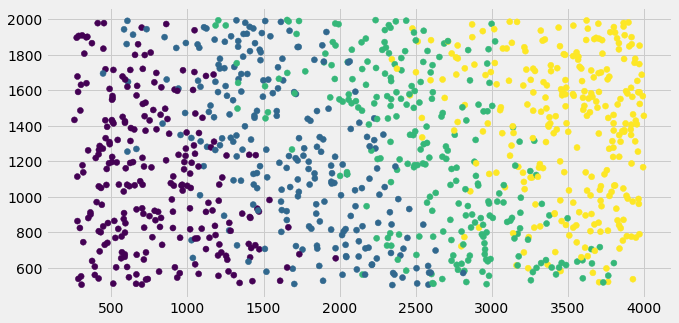

In [60]:
D = pd.read_csv(file_url)
n = 1000
Dx = D[['ram','battery_power']].to_numpy()
Dx = Dx[:n]

Dy = D['price_range'].to_numpy()
Dy = Dy[:n]

fig, ax = plt.subplots(figsize=(10,5))
ax.scatter(Dx[:,0], Dx[:,1], c = Dy)

In [61]:
from sklearn.cluster import SpectralClustering
K = 4
knn = 10

# Inicializacion del modelo  SpectralClustering y entrenamiento usando matriz laplaciana normalizada y matriz de afinidad completa
clustering_spectral = SpectralClustering(n_clusters = K, 
                                affinity = 'nearest_neighbors', n_neighbors = knn,
                                random_state = 0).fit(Dx)

In [62]:
# Obtencion de valores predichos
Dy_espectral = clustering_spectral.labels_

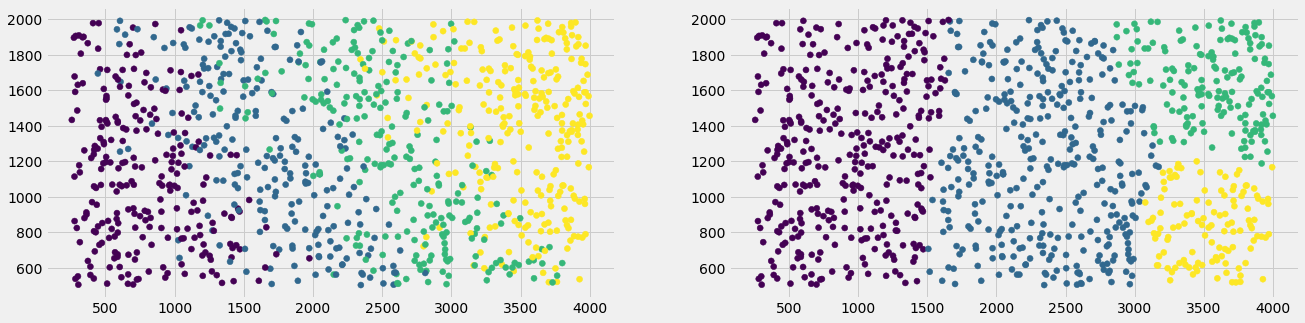

In [63]:
fig, ax = plt.subplots(1,2,figsize=(20,5))
# clustering original
ax[0].scatter(Dx[:,0], Dx[:,1], c = Dy)
# clustering spectral
ax[1].scatter(Dx[:,0], Dx[:,1], c=Dy_espectral)

In [64]:
df.loc['espectral'] = [calinski_harabasz_score(Dx, Dy_espectral),silhouette_score(Dx,Dy_espectral) ]
df

,calinski_harabasz,silhouette_score
kmeans,2791.029018,0.353710
espectral,1347.488899,0.395666


### DBSCAN

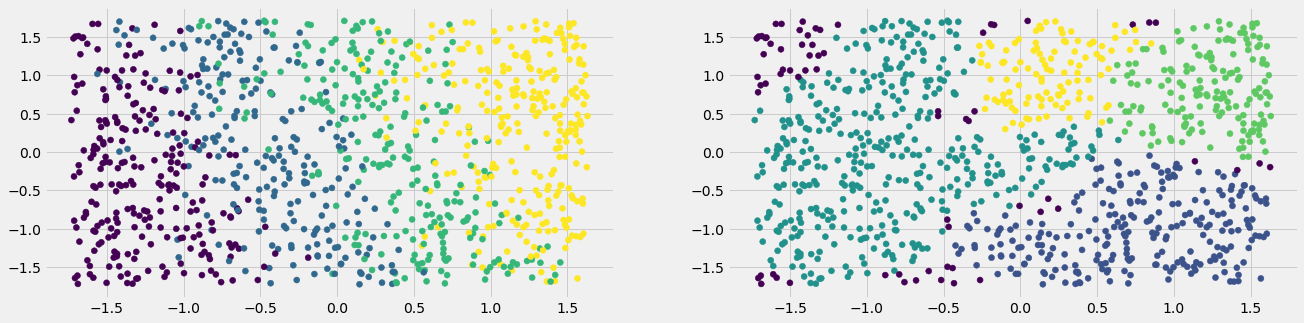

In [65]:
D = pd.read_csv(file_url)
n = 1000
Dx = D[['ram','battery_power']].to_numpy()
Dx = Dx[:n]

Dy = D['price_range'].to_numpy()
Dy = Dy[:n]

eps = 0.327
M = 30
mDistancia = euclidean_distances(Dx)
Dx = StandardScaler().fit_transform(Dx)

Dy_dbscan = DBSCAN(eps=eps, min_samples=M).fit(Dx)

fig, ax = plt.subplots(1,2,figsize=(20,5))
ax[0].scatter(Dx[:,0], Dx[:,1], c = Dy)
ax[1].scatter(Dx[:,0], Dx[:,1], c = Dy_dbscan.labels_)
plt.show()

In [48]:
df.loc['DBSCAN'] = [calinski_harabasz_score(Dx, Dy_dbscan.labels_),silhouette_score(Dx,Dy_dbscan.labels_) ]
df

,calinski_harabasz,silhouette_score
kmeans,2791.029018,0.353710
algomerativo,2369.833466,0.335606
espectral,1347.488899,0.395666
DBSCAN,401.953127,0.271991


### Probabilístico

El dataset cargado tiene 2000 instancias.


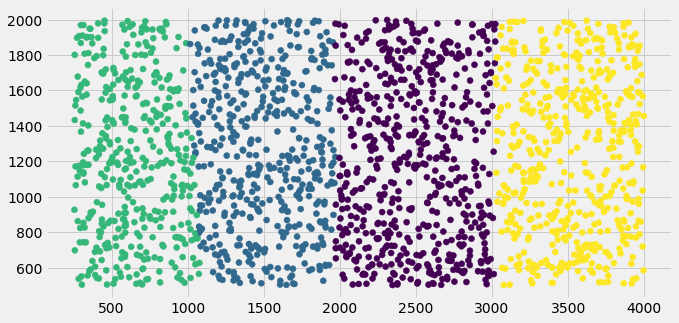

In [69]:

def matriz_confusion(cat_real, cat_pred):
    cats = np.unique(cat_real)
    clusts = np.unique(cat_pred)
    mat = np.array([[np.sum(np.logical_and(cat_real==cats[i], cat_pred==clusts[j]))
                     for j in np.arange(clusts.size)]
                    for i in np.arange(cats.size)])
    return(mat)


D = pd.read_csv(file_url)
Dx = D[['ram','battery_power']].to_numpy()
Dy =  D['price_range'].to_numpy()
print('El dataset cargado tiene',Dy.size,'instancias.')


# Se inicializa el método con el número de clústeres (componentes) a buscar
modelo = GaussianMixture(n_components = 4, max_iter = 200)
# Se aprende el modelo
modelo = modelo.fit(Dx)
# Se predicen las asignaciones a clústeres
Dy_prob = modelo.predict(Dx)

# Medimos el rendimiento del algoritmo de ScikitLearn
mC_sk = matriz_confusion(Dy,Dyp_sk)


fig, ax = plt.subplots(figsize=(10,5))
ax.scatter(Dx[:,0],Dx[:,1], c=Dy_prob)
plt.show()

In [50]:
df.loc['Probabilistico'] = [calinski_harabasz_score(Dx, Dy_prob),silhouette_score(Dx,Dy_prob) ]
df

,calinski_harabasz,silhouette_score
kmeans,2791.029018,0.353710
algomerativo,2369.833466,0.335606
espectral,1347.488899,0.395666
DBSCAN,401.953127,0.271991
Probabilistico,2774.875784,0.352398
